In [1]:
# if you haven't done so, make a new env and install required packages . I tested this with python=3.8
# 1. MAKE NEW ENVIRONMENT with conda or python virtual env
# 2. pip install -r requirements.txt

In [2]:
import numpy as np

import matplotlib.pyplot as plt

import ase

from rascal.representations import SphericalExpansion, SphericalInvariants

In [3]:
# contains input data (positions), nn features (model_6A_seed0_feat), targets (energies)
# the train and test is wrt. the NN model
data = np.load('schnet_data_features_targets_0.npz')
print(list(data.keys()))

['model_6A_seed0_feat_train', 'positions_train', 'energies_train', 'model_6A_seed0_feat_test', 'positions_test', 'energies_test']


In [4]:
positions_train = data['positions_train']
# this is just a wrapper for the atoms positions so we can compute it conveniently with our feature library
# the atomic species I just know, it is for every point the same, so I did not store it
frames_train = [ase.Atoms('CH4', positions=positions_train[i]) for i in range(len(positions_train))]

positions_test = data['positions_test']
frames_test = [ase.Atoms('CH4', positions=positions_test[i]) for i in range(len(positions_test))]


In [5]:
from ase.visualize import view
view(frames_train)

In [6]:
# this some stuff we need to do, because our librascal has a bad user-interface, logically it does nothing
for frame in frames_train:
    frame.cell = [50, 50, 50]
    frame.center()
    
for frame in frames_test:
    frame.cell = [50, 50, 50]
    frame.center()

In [7]:
energies_train = data['energies_train']
energies_test = data['energies_test']

In [8]:
frames_train = frames_train[:4000]
energies_train = energies_train[:4000]

frames_test = frames_test[:4000]
energies_test = energies_test[:4000]

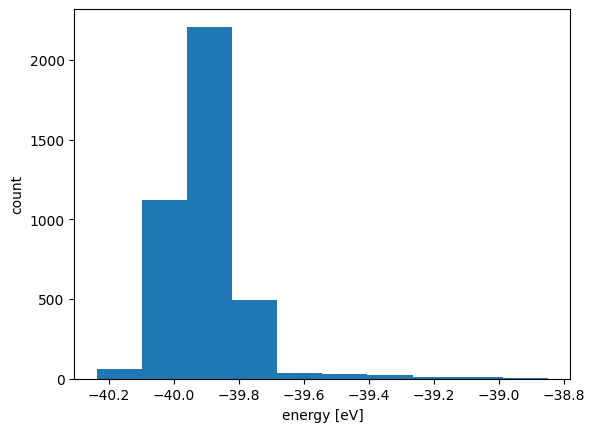

In [9]:
plt.hist(energies_train)
plt.xlabel('energy [eV]')
plt.ylabel('count')
plt.show()

### This is to remove the baseline of the energy to bring it to one scale. For our dataset it is not really important, since we have only structures with the same number of atoms an same species. We call it dressing the energies

In [10]:
from sklearn.linear_model import Ridge

species = [frame.numbers for frame in frames_train]
unique_species = np.unique(species)
print("unique species are", unique_species)
species_descriptor_train = np.array([[np.sum(frame.numbers == species) for species in unique_species] for frame in frames_train])
species_descriptor_test = np.array([[np.sum(frame.numbers == species) for species in unique_species] for frame in frames_test])

print("species descriptor for structure 0 looks like", species_descriptor_train[0])
# just a LinearRegression with a small jitter, overfitting should not happen for a two-feature model
dress_energy_model = Ridge(alpha=1e-9, fit_intercept=False).fit(species_descriptor_train, energies_train)
print("weights of model dressing energies", dress_energy_model.coef_)

dressed_energies_train = energies_train - dress_energy_model.predict(species_descriptor_train)
dressed_energies_test = energies_test - dress_energy_model.predict(species_descriptor_test)


unique species are [1 6]
species descriptor for structure 0 looks like [4 1]
weights of model dressing energies [-9.38697511 -2.35616438]


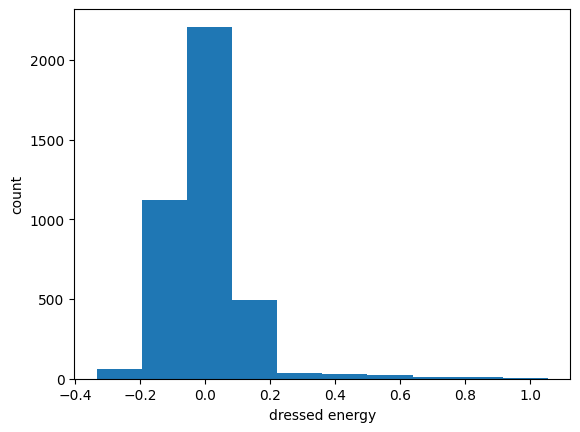

In [11]:
plt.hist(dressed_energies_train)
plt.xlabel('dressed energy')
plt.ylabel('count')
plt.show()

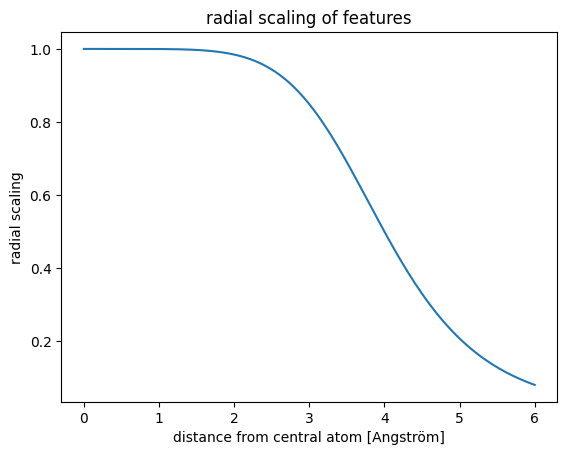

In [12]:
# define the parameters of the invariant features, important hypers are marked with comments
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6.0,
              max_radial=8, # determines feature size
              max_angular=6, # determines feature size
              gaussian_sigma_constant=0.3, # relevant hyperparameter
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              normalize=False,
              radial_basis="GTO",
              cutoff_function_type="RadialScaling",
              cutoff_function_parameters=dict( # cutoff function applied on features
                  exponent=6,
                  rate=1,
                  scale=4
              )
)

# this should just give you a feeling how the radial scaling looks like
def compute_radial_scaling(r, hypers):
    m = hypers['cutoff_function_parameters']['exponent']
    c = hypers['cutoff_function_parameters']['rate']
    r0 = hypers['cutoff_function_parameters']['scale']
    if c == 0:
        return 1/(r/r0)**m
    elif m == 0:
        return np.ones(r.shape)
    else:
        return c/(c+(r/r0)**m)

r = np.linspace(0, hypers['interaction_cutoff'], 200)
plt.plot(r, compute_radial_scaling(r, hypers))
plt.ylabel('radial scaling')
plt.xlabel('distance from central atom [Angström]')
plt.title('radial scaling of features')
plt.show()

#### We usually compute features for each environment and then sum the predicted contributions (local energies) together. In the linear model case structure descriptor is equivalent to a sum of all environments.

In [13]:
calculator = SphericalInvariants(**hypers)

# compute the representation of all the structures in frame
struc_features_train = np.sum([calculator.transform(frame).get_features(calculator) for frame in frames_train], axis=1)
struc_features_test = np.sum([calculator.transform(frame).get_features(calculator) for frame in frames_test], axis=1)


#### In the case of this dataset, we can simplify this structure descriptor approach, by just taking the C environment to prediction. It is just that the C environment contribute most of the energy while the H environments only contribute a little. The energy prediction is better if we use the structure descriptor, but for prototyping this migh be easier to play around with.

In [14]:
# computes the C environment features
cenv_features_train = calculator.transform(frames_train).get_features(calculator)[::5]
cenv_features_test = calculator.transform(frames_test).get_features(calculator)[::5]


#### We scale the features globaly. StandardScaler from sklearn does this feature-wise, since the relative scaling between our features has meaning in our case, we don't do this and we use our own scaler we implemented in our own library. It is very simple, but helps to reduce code a bit and build Pipelines.

In [15]:
from skcosmo.preprocessing import StandardFlexibleScaler
# StandardFlexibleScaler centers and normalizes feature globally
# while sklearn StandardScaler normalizes the feature individually

scaler_cenv_feat = StandardFlexibleScaler().fit(cenv_features_train)
scaler_struc_feat = StandardFlexibleScaler().fit(struc_features_train)
scaler_energies = StandardFlexibleScaler().fit(dressed_energies_train.reshape(-1,1))

In [16]:

cenv_features_train = scaler_cenv_feat.transform(cenv_features_train)
struc_features_train = scaler_struc_feat.transform(struc_features_train)
dressed_energies_train = scaler_energies.transform(dressed_energies_train.reshape(-1,1))

cenv_features_test = scaler_cenv_feat.transform(cenv_features_test)
struc_features_test = scaler_struc_feat.transform(struc_features_test)
dressed_energies_test = scaler_energies.transform(dressed_energies_test.reshape(-1,1))



In [17]:
from sklearn.linear_model import RidgeCV

def mean_squared_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def r2(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred)**2)/np.sum((y_true-np.mean(y_true))**2)

### C environment model

In [18]:
cenv_model = RidgeCV(fit_intercept=False,
                     cv=2,
                     alphas=np.geomspace(1e-3,1e-9, 20)).fit(cenv_features_train, dressed_energies_train)


MAE 0.015599599156658437
RMSE 0.022724839895087466
R2 0.9649328494812994


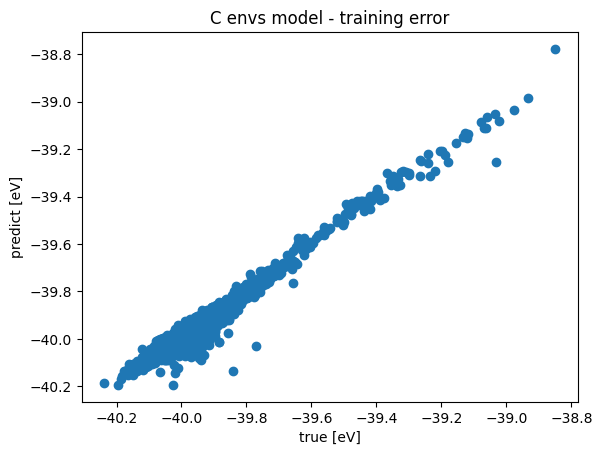

In [19]:

y_true = energies_train
y_pred = scaler_energies.inverse_transform(cenv_model.predict(cenv_features_train).reshape(-1,1)).reshape(-1) + dress_energy_model.predict(species_descriptor_train)
print("MAE", mean_squared_error(y_true, y_pred))
print("RMSE", root_mean_squared_error(y_true, y_pred))
print("R2", r2(y_true, y_pred))

plt.scatter(y_true, y_pred)
plt.title('C envs model - training error')
plt.xlabel('true [eV]')
plt.ylabel('predict [eV]')
plt.show()

MAE 0.016762621769692253
RMSE 0.02493087340452545
R2 0.9559799162101836


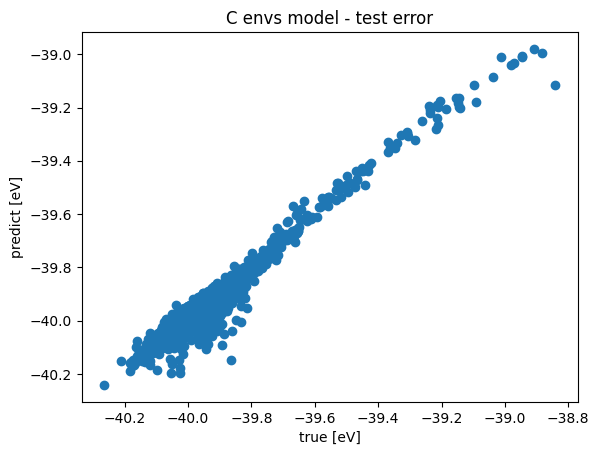

In [20]:

y_true = energies_test
y_pred = scaler_energies.inverse_transform(cenv_model.predict(cenv_features_test).reshape(-1,1)).reshape(-1) + dress_energy_model.predict(species_descriptor_test)
print("MAE", mean_squared_error(y_true, y_pred))
print("RMSE", root_mean_squared_error(y_true, y_pred))
print("R2", r2(y_true, y_pred))

plt.scatter(y_true, y_pred)
plt.title('C envs model - test error')
plt.xlabel('true [eV]')
plt.ylabel('predict [eV]')
plt.show()

### Structure model

In [ ]:
struc_model = RidgeCV(fit_intercept=False,
                     cv=2,
                     alphas=np.geomspace(1e-3,1e-9, 20)).fit(struc_features_train, dressed_energies_train)


In [ ]:

y_true = energies_train
y_pred = scaler_energies.inverse_transform(struc_model.predict(struc_features_train).reshape(-1,1)).reshape(-1) + dress_energy_model.predict(species_descriptor_train)
print("MAE", mean_squared_error(y_true, y_pred))
print("RMSE", root_mean_squared_error(y_true, y_pred))
print("R2", r2(y_true, y_pred))

plt.scatter(y_true, y_pred)
plt.title('structure model - training error')
plt.xlabel('true [eV]')
plt.ylabel('predict [eV]')
plt.show()

In [ ]:
y_true = energies_test
y_pred = scaler_energies.inverse_transform(struc_model.predict(struc_features_test).reshape(-1,1)).reshape(-1) + dress_energy_model.predict(species_descriptor_test)
print("MAE", mean_squared_error(y_true, y_pred))
print("RMSE", root_mean_squared_error(y_true, y_pred))
print("R2", r2(y_true, y_pred))

plt.scatter(y_true, y_pred)
plt.title('structure model - test error')
plt.xlabel('true [eV]')
plt.ylabel('predict [eV]')
plt.show()

### Loading NN features

#### At the moment the NN features give weird results, I am double checking this

In [ ]:
nn_features_train = data['model_6A_seed0_feat_train']
print("nn_features_train.shape", nn_features_train.shape, ": (struc, env, feat)")
# 10k strucs, each has 5 atoms, with 128 features

In [ ]:
nn_features_train = nn_features_train[:4000]

In [ ]:
cenv_nn_features_train = nn_features_train[:, 0, :]
struc_nn_features_train = np.sum(nn_features_train, axis=1)

### C environment model with NN features

In [ ]:
cenv_nn_model = RidgeCV(fit_intercept=False,
                     cv=2,
                     alphas=np.geomspace(1e-3,1e-9, 20)).fit(cenv_nn_features_train, dressed_energies_train)


In [ ]:

y_true = energies_train
y_pred = scaler_energies.inverse_transform(cenv_nn_model.predict(cenv_nn_features_train).reshape(-1,1)).reshape(-1) + dress_energy_model.predict(species_descriptor_train)
print("MAE", mean_squared_error(y_true, y_pred))
print("RMSE", root_mean_squared_error(y_true, y_pred))
print("R2", r2(y_true, y_pred))

plt.scatter(y_true, y_pred)
plt.title('C envs model - training error')
plt.xlabel('true [eV]')
plt.ylabel('predict [eV]')
plt.show()

### structure model with NN features

In [ ]:
struc_nn_model = RidgeCV(fit_intercept=False,
                     cv=2,
                     alphas=np.geomspace(1e-3,1e-9, 20)).fit(struc_nn_features_train, dressed_energies_train)


In [ ]:

y_true = energies_train
y_pred = scaler_energies.inverse_transform(struc_nn_model.predict(struc_nn_features_train).reshape(-1,1)).reshape(-1) + dress_energy_model.predict(species_descriptor_train)
print("MAE", mean_squared_error(y_true, y_pred))
print("RMSE", root_mean_squared_error(y_true, y_pred))
print("R2", r2(y_true, y_pred))

plt.scatter(y_true, y_pred)
plt.title('Structure model - training error')
plt.xlabel('true [eV]')
plt.ylabel('predict [eV]')
plt.show()

In [ ]:
# Super weird results, need to check the NN feature computation,
# since it technically has some layer reduction at the end which contain nonlinearities

